In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.7

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.7


In [234]:
from jax_dataclasses import pytree_dataclass
from flox import geom
import jax.numpy as jnp


def _det3x3_idxs():
    idxs = jnp.array([
        [[0, 0], [1, 1], [2, 2], [2, 1], [1, 2]],
        [[1, 0], [0, 1], [2, 2], [2, 1], [0, 2]],
        [[2, 0], [0, 1], [1, 2], [1, 1], [0, 2]]
    ])
    idxs = jnp.transpose(idxs, [2, 1, 0])
    signs = jnp.array([1., -1. , 1.])
    return signs, idxs


def _det3x3(m):
    signs, idxs = _det3x3_idxs()
    a, b, c, d, e = m[idxs[0], idxs[1]]
    f = a * (b * c - d * e)
    return jnp.sum(f * signs)
    

def _inv3x3_idxs():
    idxs = jnp.array([
        [[1, 1], [2, 2], [2, 1], [1, 2]],
        [[0, 2], [2, 1], [0, 1], [2, 2]],
        [[0, 1], [1, 2], [0, 2], [1, 1]],
        [[1, 2], [2, 0], [1, 0], [2, 2]],
        [[0, 0], [2, 2], [0, 2], [2, 0]],
        [[1, 0], [0, 2], [0, 0], [1, 2]],
        [[1, 0], [2, 1], [2, 0], [1, 1]],
        [[2, 0], [0, 1], [0, 0], [2, 1]],
        [[0, 0], [1, 1], [1, 0], [0, 1]]
    ]).reshape(3, 3, 4, 2)
    idxs = jnp.transpose(idxs, [3, 2, 0, 1])
    return idxs


def _inv3x3(m, det: jnp.ndarray | None = None):
    idxs = _inv3x3_idxs()
    a, b, c, d = m[idxs[0], idxs[1]]
    if det is None:
        det = _det3x3(m)
    return (a * b - c * d) / det


def general_affine_forward(x, m, t):
    det = _det3x3(m)
    return x @ m + t, jnp.log(jnp.abs(det))

def general_affine_inverse(x, m, t):
    det = _det3x3(m)
    return (x - t) @ _inv3x3(m, det=det), jnp.log(jnp.abs(det))

from flox.flow import Transform, Transformed

from jaxtyping import Float, Array


@pytree_dataclass
class GeneralAffine3x3Transform(Transform[Array, Array]):

    trafo: Float[Array, "3 3"]
    shift: Float[Array, "3"]

    def forward(self, input: Float[Array, "3"]) -> Transformed[Float[Array, "3"]]:
        return Transformed(*general_affine_forward(input, self.trafo, self.shift))

    def inverse(self, input: Float[Array, "3"]) -> Transformed[Float[Array, "3"]]:
        return Transformed(*general_affine_inverse(input, self.trafo, self.shift))


In [214]:
%timeit a(m).block_until_ready()

28.5 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [215]:
%timeit b(m).block_until_ready()

29.7 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [3]:
from jax_dataclasses import pytree_dataclass

from flox import geom
from flox.util import key_chain
from flox.flow import Transform, Transformed

import jax
import jax.numpy as jnp

from jax import Array


@pytree_dataclass(frozen=True)
class Radial:
    rot: Array
    rad: Array

def to_radial(pos):
    return Radial(
        geom.unit(pos),
        geom.norm(pos)
    )

def to_radial_log_jac(pos):
    pos2 = pos ** 2
    return -jnp.log(
        (pos2 ** 2).sum() + 2 * (pos2 * jnp.roll(pos2, -1)).sum()
    )

def from_radial(pos: Radial):
    return pos.rot * pos.rad


def from_radial_log_jac(pos: Radial):
    rad2 = pos.rad ** 2
    return jnp.log(rad2 ** 3 + rad2 ** 2)


class RadialTransform(Transform[Array, Radial]):

    def forward(self, input: Array) -> Transformed[Radial]:
        return Transformed(
            to_radial(input), to_radial_log_jac(input)
        )

    def inverse(self, input: Radial) -> Transformed[Array]:
        return Transformed(
            from_radial(input), from_radial_log_jac(input)
        )

2022-11-26 18:16:06.856165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2022-11-26 18:16:06.856254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2022-11-26 18:16:06.856262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
from dataclasses import astuple
from typing import Generic, TypeVar

import jax
import jax.numpy as jnp
from jax_dataclasses import pytree_dataclass
from jaxtyping import Array, Float  # type: ignore

import flox
from flox._src.flow import rigid
from flox.flow import Transform, Transformed

Scalar = Float[Array, ""] | float
Vector3 = Float[Array, "... 3"]
Quaternion = Float[Array, "... 4"]
Auxiliary = Float[Array, f"... AUX"]

AtomRepresentation = Float[Array, "... MOL 4 3"]

BoxSize = Vector3

__all__ = [
    "InternalCoordinates",
    "RigidRepresentation",
    "AtomRepresentation",
    "RigidTransform",
    "Box",
    "State",
]


@pytree_dataclass(frozen=True)
class InternalCoordinates:
    d_OH1: Scalar = jnp.array(0.095712)
    d_OH2: Scalar = jnp.array(0.095712)
    a_HOH: Scalar = jnp.array(104.52 * jnp.pi / 180)
    d_OM: Scalar = jnp.array(0.0125)
    a_OM: Scalar = jnp.array(52.259937 * jnp.pi / 180)


@pytree_dataclass(frozen=True)
class RigidRepresentation:
    rot: Quaternion
    pos: Vector3
    ics: InternalCoordinates = InternalCoordinates()


@pytree_dataclass(frozen=True)
class RigidRadialRepresentation:
    rot: Quaternion
    pos: Radial
    ics: InternalCoordinates = InternalCoordinates()


AtomRepresentation = Float[Array, "... MOL 4 3"]

Representation = TypeVar(
    "Representation", RigidRepresentation, AtomRepresentation, RigidRadialRepresentation
)


@pytree_dataclass(frozen=True)
class Box:
    min: jnp.ndarray
    max: jnp.ndarray

    @property
    def size(self):
        return self.max - self.min


@pytree_dataclass(frozen=True)
class State(Generic[Representation]):
    mol: Representation
    aux: Auxiliary
    box: Box


def to_rigid(pos: AtomRepresentation) -> Transformed[RigidRepresentation]:
    q, p, *_ = rigid.from_euclidean(pos[:3])
    ldj = rigid.from_euclidean_log_jacobian(pos[:3])
    return Transformed(RigidRepresentation(q, p), ldj)


def from_rigid(rp: RigidRepresentation) -> Transformed[AtomRepresentation]:
    r_OM = rp.ics.d_OM * jnp.array(
        [jnp.sin(rp.ics.a_OM), 0.0, jnp.cos(rp.ics.a_OM)]
    )
    r_OM = flox.geom.qrot3d(rp.rot, r_OM)
    pos = rigid.to_euclidean(rp.rot, rp.pos, *astuple(rp.ics)[:3])
    ldj = rigid.to_euclidean_log_jacobian(rp.rot, rp.pos, *astuple(rp.ics)[:3])
    pos = jnp.concatenate([pos, (pos[0] + r_OM)[None]], axis=0)
    return Transformed(pos, ldj)


class RigidTransform(Transform[AtomRepresentation, RigidRepresentation]):
    def forward(
        self, inp: AtomRepresentation
    ) -> Transformed[RigidRepresentation]:
        return to_rigid(inp)

    def inverse(
        self, inp: RigidRepresentation
    ) -> Transformed[AtomRepresentation]:
        return from_rigid(inp)


In [5]:
chain = key_chain(42)


In [6]:
from dataclasses import astuple

pos = jax.random.normal(next(chain), (3,))
def foo(pos):
    rot, rad = astuple(to_radial(pos))
    return jnp.concatenate([rot, rad[None]])



J = jax.jacobian(foo)(pos)
jnp.log(jnp.linalg.det(J.T @ J)), to_radial_log_jac(pos), 

(DeviceArray(-2.3146317, dtype=float32), DeviceArray(-2.314632, dtype=float32))

In [7]:
def bar(pos):
    rot, rad = jnp.split(pos, (3,))
    return from_radial(Radial(rot, rad))

from_radial_log_jac(to_radial(pos))


rot, rad = astuple(to_radial(pos))
vec = jnp.concatenate([rot, rad[None]])

J = jax.jacobian(bar)(vec)
jnp.log(jnp.linalg.det(J @ J.T)), from_radial_log_jac(to_radial(pos)), 

(DeviceArray(3.745274, dtype=float32), DeviceArray(3.745274, dtype=float32))

In [104]:
import jax
import jax.numpy as jnp

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import flox
from flox.util import key_chain
from flox import geom

# from ribflox.rep import State, RigidRepresentation, RigidTransform, AtomRepresentation, Box

seed = 42
chain = key_chain(seed)

ROT_DIM = 4
POS_DIM = 3

NUM_MOL = 16

AUX_DIM = 16 * 4

# box = jnp.array([0.92233076, 0.80326499, 0.71133756])

# s = jax.vmap(sample_state)(jax.random.split(next(chain), 128))


gpu


In [105]:
from matplotlib import pyplot as plt

from flox.flow import Moebius
from flox.util import unpack

@jax.value_and_grad
def shift_fn(x, s, a):
    s_ = jnp.stack([
        jnp.cos(s * 2 * jnp.pi),
        jnp.sin(s * 2 * jnp.pi)
    ]) * a
    x_ = jnp.stack([
        jnp.cos((x - 0.5) * 2 * jnp.pi),
        jnp.sin((x - 0.5) * 2 * jnp.pi)
    ])
    y_, _ = unpack(Moebius(s_).forward(x_))
    y = jnp.arctan2(y_[1], y_[0])
    return y / (2 * jnp.pi) + 0.5


In [106]:
from functools import partial
from jax_dataclasses import pytree_dataclass

from jaxtyping import Float, Array

Scalar = Array

from flox.flow import Transform, Transformed
from flox.geom import squared_norm, unit
from jaxopt._src.lbfgs import LBFGS

from flox._src.flow.convex import forward_log_volume, inverse_log_volume

def numeric_inverse_v2(
    forward,
    solver_factory = partial(LBFGS),
    threshold: float = 1e-5,
    max_iters: int = 20,
):
    def criterion(
        candidate, target
    ) -> Scalar:
        # return -jnp.arccos(jnp.clip(jnp.inner(
        #     forward(unit(candidate)), target
        # ), -0.99, 0.99))
        return squared_norm(forward(unit(candidate)) - target)

    solver = LBFGS(criterion, maxiter=30, tol=1e-5)

    # @wraps(forward)
    def solve(init):

        return unit(solver.run(init, init).params)
        cand = init
        for i in range(50):
            l, g = jax.value_and_grad(criterion)(cand, init)
            cand = cand - 0.5 * g
            print(l)
        return unit(cand)

    return solve


def potential(
    input: Float[Array, "N"],
    ctrlpts: Float[Array, "M N"],
    weights: Float[Array, "M"],
    bias: Float[Array, "M"],
    eps: Scalar,
) -> Scalar:
    """Simple convex potential"""
    # ctrlpts_ = jnp.concatenate([ctrlpts, input[None]], axis=0)

    # norm = jax.vmap(geom.norm)(ctrlpts)
    # norm = 1. + jax.nn.sigmoid(norm)

    ctrlpts = jax.vmap(lambda x : x / (1 + geom.norm(x)) * 10.)(ctrlpts)
    # weights = jax.nn.tanh(weights)
    bias = jax.nn.tanh(bias) * 5

    y = jnp.log(jax.nn.softplus(bias) + jnp.cosh(ctrlpts @ input))
    w = jax.nn.softmax(weights)
    return w @ y + eps * jnp.square(input).sum()


def potential_gradient(
    input: Float[Array, "N"],
    ctrlpts: Float[Array, "M N"],
    weights: Float[Array, "M+1"],
    bias: Float[Array, "M+1"],
    eps: Scalar,
) -> Float[Array, "N"]:
    return unit(jax.grad(potential)(input, ctrlpts, weights, bias, eps))

@pytree_dataclass(frozen=True)
class ConvexPotential:
    ctrlpts: Array
    weights: Array
    bias: Array
    eps: Array

    def forward(self, input: Array) -> Transformed[Array]:
        output = potential_gradient(
            input, self.ctrlpts, self.weights, self.bias, self.eps
        )
        logprob = forward_log_volume(partial(potential_gradient, ctrlpts=self.ctrlpts, weights=self.weights, bias=self.bias, eps=self.eps))(
            input
        )
        return Transformed(output, logprob)

    def inverse(self, input: Array) -> Transformed[Array]:
        output = numeric_inverse_v2(
            partial(potential_gradient, ctrlpts=self.ctrlpts, weights=self.weights, bias=self.bias, eps=self.eps)
        )(input)

        def bound(out):
            return potential_gradient(out, self.ctrlpts, self.weights, self.bias, self.eps)
            
        logprob = inverse_log_volume(bound)(output)
        return Transformed(output, logprob)

In [107]:

import numpy as np

raw = np.load("/group/ag_cmb/scratch/minvernizzi/so3-flow/bck.0.MDtraj-iceIh_tip4pew-T270.npz")
# raw = np.load("/group/ag_cmb/scratch/minvernizzi/so3-flow/MDtraj-iceIh_T270.npz")
# raw = np.load("./data/water/md.npz")

In [71]:

from jax_dataclasses import pytree_dataclass
from numpy import dtype

from flox.flow import Transformed


KeyArray = jax.random.PRNGKeyArray | jnp.ndarray

@pytree_dataclass(frozen=True)
class Data:
    positions: jnp.ndarray
    box: jnp.ndarray
    energy: jnp.ndarray


# data = Data(**np.load("./data/water/data-iceIh_tip4pew-T270.npz"))
# data = Data(**np.load("./data/water/md.npz"))


data = Data(*raw.values())
# offset = data.positions.reshape(-1, 3).min(axis=0)
# scale = data.positions.reshape(-1, 3).max(axis=0) - offset



# BOX = Box(
#     min=jnp.minimum(data.positions.reshape(-1, 3).min(axis=0), jnp.zeros(3)),
#     max=jnp.maximum(data.positions.reshape(-1, 3).max(axis=0), jnp.array([0.92233076, 0.80326499, 0.71133756])),
# )


BOX = Box(
    jnp.zeros(3),
    jnp.diag(data.box[0]) if data.box[0].shape != (3,) else data.box[0]
)




data = jax.tree_map(jnp.array, data)

def shuffle_data(key, data):
    idx = jnp.arange(len(data.positions))
    idx = jax.random.shuffle(key, idx)
    return jax.tree_map(
        lambda x: x[idx], data
    )

data = shuffle_data(next(chain), data)

def sample_state_from_data(key: KeyArray, data: Data) -> Transformed[State[AtomRepresentation]]:
    aux = jax.random.normal(key, shape=(AUX_DIM,))

    
    pos = data.positions.reshape(NUM_MOL, 4, 3)
    # pos = jax.vmap(jax.vmap(partial(from_box, box=box)))(pos)
    # pos = jnp.stack([
    #     jnp.cos(2 * jnp.pi * pos),
    #     jnp.sin(2 * jnp.pi * pos),
    # ], axis=-1)
    return Transformed(State(
        mol= pos,
        aux=aux,
        box=BOX,
    ), data.energy)


def smooth_maximum(a, bins=1000, sigma=10000, window=1000):
    freqs, bins = jnp.histogram(a, bins=bins)
    gx = np.arange(-4*sigma, 4*sigma, window)
    gaussian = np.exp(-(gx/sigma)**2/2)
    freqs = jnp.convolve(
        freqs, gaussian, mode="same"
    )
    return bins[jnp.argmax(freqs)]


# oxy = data.positions.reshape(-1, 16, 4, 3)[:, :, 0] % BOX.size
# modes, hist = jax.vmap(jax.vmap(smooth_maximum, in_axes=1, out_axes=0), in_axes=2, out_axes=1)(oxy)

import equinox as eqx

class PositionPrior(eqx.Module):

    box: Box
    modes: Array

    mean: Array
    cov_sqrt: Array
    inv_cov_sqrt: Array

    def __init__(self, data: Data, box: Box):
        self.box = box
        oxy = data.positions.reshape(data.positions.shape[0], -1, 4, 3)[:, :, 0] % box.size
        
        self.modes = jax.vmap(jax.vmap(smooth_maximum, in_axes=1, out_axes=0), in_axes=2, out_axes=1)(oxy)
        rs = jax.vmap(lambda x: geom.Torus(box.size).tangent(x, x - self.modes))(oxy)

        rs = rs.reshape(rs.shape[0], -1)
        self.mean = jnp.mean(rs, axis=0)

        C = jnp.cov(rs.T)
        D, U = jnp.linalg.eigh(C)
        D = jnp.sqrt(D)
        self.cov_sqrt = jnp.diag(D) @ U.T
        self.inv_cov_sqrt = U @ jnp.diag(1. / (D + 1e-6))

    def sample(self, key: KeyArray):
        r = jax.random.normal(key, shape=(16 * 3,))
        r = (self.cov_sqrt.T @ r + self.mean).reshape(16, 3)
        r = geom.Torus(BOX.size).shift(self.modes, r)
        return r


    def log_prob(self, x: Array):
        x = x.reshape(self.modes.shape)
        r = geom.Torus(self.box.size).tangent(x, x - self.modes)
        r = r.reshape(-1)
        return -0.5 * jnp.square((r - self.mean) @ self.inv_cov_sqrt).sum()





pos_prior = PositionPrior(data, BOX)

/storage/mi/jonkhler/miniconda3/envs/py310/lib/python3.10/site-packages/jax/_src/random.py:399: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


In [72]:
# Computes I_{nu+1}(x) / I_{nu}(x).
# Amos (1974), Computation of modified Bessel functions and
# their ratios, Mathematics of Computation, 28 (125), 235-251
def bessel_ratio(nu, x, threshold=1e-6):
    l = []
    res = jnp.array(2.)
    k = 0
    while True:
        s = nu + k + 0.5
        l.append(
            x / (s + jnp.hypot(s + 1, x))
        )
        m = k
        while m > 0:
            r = jnp.sqrt(l[m] / l[m-1])
            s = nu + m
            l[m-1] = x / (s + jnp.hypot(s, x * r))
            m -= 1
        if jnp.abs(l[0] - res) < threshold:
            return res;
        res = l[0]
        k += 1
        if k > 100:
            raise ValueError()

def mle_kappa(r, p, threshold=1e-6):
    k = r * (p - r * r) / (1 - r * r)
    ak = 1
    delta = 1
    s = 0
    while jnp.abs(delta) > threshold:
        ak = bessel_ratio(p / 2 - 1, k)
        delta = (ak - r) / (1 - ak * ak - (p - 1) / k * ak)
        k -= delta
        s += 1
        if s > 100:
            break
    return k

def mle_loc(q):
    x = jnp.mean(q, axis=0)
    r = geom.norm(x)
    return geom.unit(x), r

def mle_vmf_params(q):
    loc, r = mle_loc(q)
    scale = mle_kappa(r, q.shape[-1])
    return loc, scale

In [73]:
from tensorflow_probability.substrates import jax as tfp

class RotationPrior(eqx.Module):
    loc: Array
    scale: Array
    vmf: tfp.distributions.VonMisesFisher
    
    def __init__(self, data):

        def quat(x):
            return jax.vmap(RigidTransform().forward)(x).obj.rot

        pos = data.positions
        quats = jax.vmap(quat)(pos.reshape(pos.shape[0], -1, 4, 3))

        locs = []
        scales = []
        for i in range(quats.shape[1]):
            qs = quats[:, i]
            loc, scale = mle_vmf_params(qs)
            locs.append(loc)
            scales.append(scale)
        
        self.loc = jnp.stack(locs)
        self.scale = jnp.stack(scales)
        self.vmf = tfp.distributions.VonMisesFisher(self.loc, self.scale)
        
    def sample(self, key: KeyArray):
        return jax.vmap(geom.unit)(jax.random.normal(key, shape=self.loc.shape))
        return self.vmf.sample(seed=key)
    
    def log_prob(self, x: Array):
        parts = jnp.stack([
            self.vmf.log_prob(x) + jnp.log(0.5),
            self.vmf.log_prob(-x) + jnp.log(0.5)
        ])
        return jax.nn.logsumexp(parts)

rot_prior = RotationPrior(data)

In [74]:

def quat(x):
    return jax.vmap(RigidTransform().forward)(x).obj.rot

pos = data.positions


In [75]:
class FullAffine(Transform[Array, Array]):

    def forward(self, input: Array) -> Transformed[Array]:
        return super().forward(input)

    def inverse(self, input: Array) -> Transformed[Array]:
        return super().inverse(input)

In [296]:
from functools import partial
from turtle import forward
from typing import Any, Generic, TypeAlias, TypeVar, cast
from wsgiref.handlers import format_date_time
import distrax
from jax import Array

from collections.abc import Callable

import lenses
from numpy import ndarray
from ribflox.flow import full_step, WrappedLens
from lenses import lens
from flox.flow import Transform, LayerStack, Transformed, Affine, VectorizedTransform, Lambda, Moebius, DoubleMoebius, Pipe, bind, pure, DistraxWrapper, Inverted
from flox._src.nn.modules import dense
from flox.util import unpack, LensLike, Lens

import equinox as eqx

from jax_dataclasses import pytree_dataclass

KeyArray = jax.random.PRNGKeyArray | jnp.ndarray

LATENT = 128
HIDDEN = 128
CTRL_PTS = 10

NUM_LAYERS = 3

RR: TypeAlias= RigidRepresentation
RRR: TypeAlias = RigidRadialRepresentation
AR: TypeAlias = AtomRepresentation



@pytree_dataclass(frozen=True)
class Box:
    min: jnp.ndarray
    max: jnp.ndarray

    @property
    def size(self):
        return self.max - self.min

def to_box(pos, box):
    return pos * box.size + box.min

def from_box(pos, box):
    return (pos - box.min) / box.size


class CircularEmbedding:

    def forward(self, input: Array) -> Transformed[Array]:
        output = jnp.stack([
            jnp.cos((input - 0.5) * 2 * jnp.pi),
            jnp.sin((input - 0.5) * 2 * jnp.pi)
        ], axis=-1)
        return Transformed(output, jnp.zeros(()))

    def inverse(self, input: Array) -> Transformed[Array]:
        output = jnp.arctan2(input[..., 1], input[..., 0])
        return Transformed(output / (2 * jnp.pi) + 0.5, jnp.zeros(()))



class Unbox:

    def forward(self, input: State[RR]) -> Transformed[State[RR]]:
        return Transformed(
            lenses.bind(input).mol.pos.set((input.mol.pos - input.box.min) / input.box.size),
            -jnp.log(input.box.size).sum()
        )

    def inverse(self, input: State[RR]) -> Transformed[State[RR]]:
        return Transformed(
            lenses.bind(input).mol.pos.set(input.mol.pos * input.box.size + input.box.min),
            jnp.log(input.box.size).sum()
        )

class ToRigid:

    def forward(self, input: State[AR]) -> Transformed[State[RR]]:
        mol, ldj = unpack(VectorizedTransform(RigidTransform()).forward(input.mol))
        return Transformed(
            lenses.bind(input).mol.set(mol),
            ldj
        )

    def inverse(self, input: State[RR]) -> Transformed[State[AR]]:
        mol, ldj = unpack(VectorizedTransform(RigidTransform()).inverse(input.mol))
        return Transformed(
            lenses.bind(input).mol.set(mol),
            ldj
        )


@pytree_dataclass
class DisplacementEncoder:

    prior: PositionPrior

    def __call__(self, box, diff):
        pos = geom.Torus(box.size).shift(self.prior.modes, diff)
        pos = pos / box.size
        return  jnp.stack([
            jnp.cos((pos - 0.5) * 2 * jnp.pi),
            jnp.sin((pos - 0.5) * 2 * jnp.pi)
        ], axis=-1)


@pytree_dataclass(frozen=True)
class DisplacementEmbedding:

    prior: PositionPrior

    def forward(self, input: State[RR]) -> Transformed[State[RR]]:

        box = input.box
        pos = input.mol.pos

        diff = geom.Torus(box.size).tangent(pos, pos - self.prior.modes)
        ldj = jnp.zeros(())

        return Transformed(
            cast(State[RR], lenses.bind(input).mol.pos.set(diff)),
            ldj
        )

    def inverse(self, input: State[RR]) -> Transformed[State[RR]]:

        box = input.box
        diff = input.mol.pos

        pos = geom.Torus(box.size).shift(self.prior.modes, diff)        
        ldj = jnp.zeros(())

        return Transformed(
            cast(State[RR], lenses.bind(input).mol.pos.set(pos)),
            ldj
        )

@pytree_dataclass(frozen=True)
class DisplacementRadialEmbedding:

    prior: PositionPrior

    def forward(self, input: State[RR]) -> Transformed[State[RRR]]:

        box = input.box
        pos = input.mol.pos

        diff = geom.Torus(box.size).tangent(pos, pos - self.prior.modes)
        rad, ldj = unpack(VectorizedTransform(RadialTransform()).forward(diff))

        return Transformed(
            cast(State[RRR], lenses.bind(input).mol.pos.set(rad)),
            ldj
        )

    def inverse(self, input: State[RRR]) -> Transformed[State[RR]]:

        box = input.box
        rad = input.mol.pos

        diff, ldj = unpack(VectorizedTransform(RadialTransform()).inverse(rad))
        pos = geom.Torus(box.size).shift(self.prior.modes, diff)        

        return Transformed(
            cast(State[RR], lenses.bind(input).mol.pos.set(pos)),
            ldj
        )


S = TypeVar("S")
T = TypeVar("T")

A = TypeVar("A")
B = TypeVar("B")
C = TypeVar("C")
D = TypeVar("D")

def map_lens(
    lens: lenses.ui.UnboundLens
) -> LensLike[Any, Any, C, D]:
    return Lens[Any, Any, C, D](
        lambda a: lens.get()(a),
        lambda a, c: lens.set(c)(a)
    )



def initial_transform(prior: PositionPrior) -> Transform[State[AR], State[RRR]]:
    return Pipe((
        ToRigid(),
        DisplacementEmbedding(prior),
    ))


def final_transform(prior: PositionPrior) -> Transform[State[RRR], State[RR]]:
    return Pipe((
        Inverted(DisplacementEmbedding(prior)),
    ))

def dense(
    units: tuple[int, ...], activation, *, key
) -> eqx.nn.Sequential:
    chain = key_chain(key)
    num_layers = len(units) - 1
    layers = []
    for i, (inp, out) in enumerate(zip(units[:-1], units[1:])):
        layers.append(eqx.nn.LayerNorm(inp, elementwise_affine=True))
        layers.append(eqx.nn.Linear(inp, out, use_bias=True, key=next(chain)))
        if i < num_layers - 1:
            if activation is not None:
                if isinstance(activation, eqx.Module):
                    layers.append(activation)
                else:
                    layers.append(eqx.nn.Lambda(activation))
    return eqx.nn.Sequential(layers)



class SimpleRotEncoder(eqx.Module):

    encoder: eqx.nn.Sequential

    def __call__(self, quat):
        quat = quat * 0.
        a = self.encoder(quat)
        b = self.encoder(-quat)
        y = jnp.stack([a, b], axis=0)
        weight = jax.nn.softmax(y, axis=0)
        z = (weight * y).sum(0)
        return z

HIDDEN: int = 256

activation = jax.nn.silu

class AuxUpdate(eqx.Module):

    net: eqx.nn.Sequential
    quat_symmetrizer: SimpleRotEncoder

    disp_encoder: DisplacementEncoder

    def __init__(self, disp_encoder: DisplacementEncoder, *, key):
        num_inp = (
            HIDDEN
            + NUM_MOL * 3 * 2
        )
        num_out = 2 * AUX_DIM
        self.quat_symmetrizer = SimpleRotEncoder(
            dense((NUM_MOL * 4, HIDDEN), activation, key=next(chain))
        )
        self.net = dense(
            (num_inp, HIDDEN, num_out), activation, key=next(chain)
        )
        self.disp_encoder = disp_encoder

    def compute_params(self, state: State[RR]):
        feats = jnp.concatenate([
            self.quat_symmetrizer(state.mol.rot.reshape(-1)),
            self.disp_encoder(state.box, state.mol.pos).reshape(-1),
        ])
        params = self.net(feats) * 1e-2

        shift, scale = jnp.split(params, 2, -1)
        shift = jnp.reshape(shift, state.aux.shape)
        scale = jnp.reshape(scale, state.aux.shape) 
        return shift, scale

    def forward(self, input: State[RR]) -> Transformed[State[RR]]:
        shift, scale = self.compute_params(input)
        new_aux, ldj = unpack(Affine(shift, scale).forward(input.aux))
        input = lenses.bind(input).aux.set(new_aux)
        return Transformed(input, ldj)

    def inverse(self, input: State[RR]) -> Transformed[State[RR]]:
        shift, scale = self.compute_params(input)
        new_aux, ldj = unpack(Affine(shift, scale).inverse(input.aux))
        input = lenses.bind(input).aux.set(new_aux)
        return Transformed(input, ldj)


class PosAffineUpdate(eqx.Module):

    net: eqx.nn.Sequential
    quat_symmetrizer: SimpleRotEncoder

    def __init__(self, range_min: float = 0., range_max: float = 0.2, num_bins: int = 10, *, key: KeyArray):
        num_inp = (
            AUX_DIM
            + HIDDEN
        )
        num_out = NUM_MOL * (3 * 4)
        self.quat_symmetrizer = SimpleRotEncoder(
            dense((NUM_MOL * 4, HIDDEN), activation, key=next(chain))
        )
        self.net = dense(
            (num_inp, HIDDEN, num_out), activation, key=next(chain)
        )

    def compute_params(self, state: State[RR]) -> tuple[Array, Array]:
        feats = jnp.concatenate([
            state.aux,
            self.quat_symmetrizer(state.mol.rot.reshape(-1)),
        ])
        params = self.net(feats) * 1e-2
        params = params.reshape(
            (NUM_MOL, 3, 4))
        trafo, shift = jnp.split(params, (3,), axis=-1)
        trafo = trafo + jnp.eye(3)[None]
        shift = jnp.reshape(shift, (NUM_MOL, -1))
        return trafo, shift

    def forward(self, input: State[RR]) -> Transformed[State[RR]]:
        trafo, shift = self.compute_params(input)

        out, ldj = unpack(VectorizedTransform(
            GeneralAffine3x3Transform(
                trafo, shift
            )
        ).forward(input.mol.pos))
        return Transformed(
            lenses.bind(input).mol.pos.set(out),
            ldj
        )

    def inverse(self, input: State[RR]) -> Transformed[State[RR]]:
        trafo, shift = self.compute_params(input)

        out, ldj = unpack(VectorizedTransform(
            GeneralAffine3x3Transform(
                trafo, shift
            )
        ).inverse(input.mol.pos))
        return Transformed(
            lenses.bind(input).mol.pos.set(out),
            ldj
        )

class PosRadUpdate(eqx.Module):

    net: eqx.nn.Sequential
    quat_symmetrizer: SimpleRotEncoder
    num_bins: int
    num_params: int
    range_min: float
    range_max: float

    def __init__(self, range_min: float = 0., range_max: float = 0.2, num_bins: int = 10, *, key: KeyArray):
        num_inp = (
            AUX_DIM
            + HIDDEN
            + NUM_MOL * 3
        )
        self.num_bins = num_bins
        self.range_min = range_min
        self.range_max = range_max
        self.num_params = (3 * num_bins + 1)
        num_out = self.num_params * NUM_MOL * 1
        self.quat_symmetrizer = SimpleRotEncoder(
            dense((NUM_MOL * 4, HIDDEN), activation, key=next(chain))
        )
        self.net = dense(
            (num_inp, HIDDEN, num_out), activation, key=next(chain)
        )

    def compute_params(self, state: State[RRR]) -> Array:
        feats = jnp.concatenate([
            state.aux,
            self.quat_symmetrizer(state.mol.rot.reshape(-1)),
            state.mol.pos.rot.reshape(-1)
        ])
        params = self.net(feats)
        
        params = params.reshape(
            (*state.mol.pos.rad.shape, (3 * self.num_bins + 1)))
        return params * 1e-2

    def forward(self, input: State[RRR]) -> Transformed[State[RRR]]:
        params = self.compute_params(input)

        out, ldj = unpack(DistraxWrapper(
            distrax.RationalQuadraticSpline(
                params, self.range_min, self.range_max
            )
        ).forward(input.mol.pos.rad))
        print(out.shape)
        return Transformed(
            lenses.bind(input).mol.pos.rad.set(out),
            ldj
        )

    def inverse(self, input: State[RRR]) -> Transformed[State[RRR]]:
        params = self.compute_params(input)

        out, ldj = unpack(DistraxWrapper(
            distrax.RationalQuadraticSpline(
                params, self.range_min, self.range_max
            )
        ).inverse(input.mol.pos.rad))
        return Transformed(
            lenses.bind(input).mol.pos.rad.set(out),
            ldj
        )


class PosRotUpdate(eqx.Module):

    net: eqx.nn.Sequential
    quat_symmetrizer: SimpleRotEncoder

    def __init__(
        self,
        key: KeyArray
    ):
        chain = key_chain(key)
        num_out = NUM_MOL * 3
        num_inp = (
            AUX_DIM
            + HIDDEN
            + NUM_MOL
        )
        self.quat_symmetrizer = SimpleRotEncoder(
            dense((NUM_MOL * 4, HIDDEN), activation, key=next(chain))
        )
        self.net = dense(
            (num_inp, HIDDEN, num_out), activation, key=next(chain)
        )

    def compute_params(self, state: State[RRR]) -> Array:
        feats = jnp.concatenate([
            state.aux,
            self.quat_symmetrizer(state.mol.rot.reshape(-1)),
            state.mol.pos.rad.reshape(-1)
        ])
        params = self.net(feats)
        params = params.reshape(state.mol.pos.rot.shape)
        params = jax.vmap(
            lambda p: p / (1 + geom.norm(p)) * 0.99
        )(params)
        return params * 1e-2

    def forward(self, input: State[RRR]) -> Transformed[State[RRR]]:
        range_min = 0.
        range_max = 0.2

        params = self.compute_params(input)

        out, ldj = unpack(VectorizedTransform(Moebius(params)).forward(input.mol.pos.rot))
        return Transformed(
            lenses.bind(input).mol.pos.rot.set(out),
            ldj
        )

    def inverse(self, input: State[RRR]) -> Transformed[State[RRR]]:
        range_min = 0.
        range_max = 0.2

        params = self.compute_params(input)

        out, ldj = unpack(VectorizedTransform(Moebius(params)).inverse(input.mol.pos.rot))
        return Transformed(
            lenses.bind(input).mol.pos.rot.set(out),
            ldj
        )


def compute_splits(
    tot: int,
    inp: int,
) :
    assert (tot - 2) % (inp + 2) == 0
    nctrl = (tot - 2) // (inp + 2)
    splits = [
        nctrl * (0 + inp),
        nctrl * (1 + inp) + 1,
    ]
    return splits


def compute_total_dim(nctrl: int, inp: int) -> int:
    return nctrl * inp + 2 * (nctrl + 1)


num_ctrl_pts = 10



class RotUpdate(eqx.Module):

    params: eqx.nn.Sequential

    def __init__(self, key):
        chain = key_chain(key)
        self.params = dense((AUX_DIM + 2 * NUM_MOL * POS_DIM, HIDDEN, HIDDEN, NUM_MOL * compute_total_dim(num_ctrl_pts, 4)), activation, key=next(chain))

    def forward(self, input: State[RigidRepresentation]) -> Transformed[State[RigidRepresentation]]:
        params = self.params(
            jnp.concatenate([
                input.aux.reshape(-1),
                input.mol.pos.reshape(-1),
                # jnp.cos(input.mol.pos.reshape(-1, 3) * 2 * jnp.pi).reshape(-1),
                # jnp.sin(input.mol.pos.reshape(-1, 3) * 2 * jnp.pi).reshape(-1),
            ]) 
        )
        params = params.reshape(NUM_MOL, -1) * 0.1
        ctrlpts, weights, bias = jnp.split(
            params, compute_splits(params.shape[-1], 4), axis=-1  # type: ignore
        )
        ctrlpts = ctrlpts.reshape(
            NUM_MOL, num_ctrl_pts, 4
        )

        print(ctrlpts.shape, weights.shape, bias.shape)


        transform = VectorizedTransform(ConvexPotential(ctrlpts, weights, bias, eps=1e-3))
        new_rot, ldj = unpack(transform.forward(input.mol.rot))
        input = lenses.bind(input).mol.rot.set(new_rot)
        return Transformed(input, ldj)

    def inverse(self, input: State[RigidRepresentation]) -> Transformed[State[RigidRepresentation]]:
        params = self.params(
            jnp.concatenate([
                input.aux.reshape(-1),
                input.mol.pos.reshape(-1),
                # jnp.cos(input.mol.pos.reshape(-1, 3) * 2 * jnp.pi).reshape(-1),
                # jnp.sin(input.mol.pos.reshape(-1, 3) * 2 * jnp.pi).reshape(-1),
            ]) 
        )
        params = params.reshape(NUM_MOL, -1) * 0.1
        ctrlpts, weights, bias = jnp.split(
            params, compute_splits(params.shape[-1], 4), axis=-1  # type: ignore
        )
        ctrlpts = ctrlpts.reshape(
            NUM_MOL, num_ctrl_pts, 4
        )

        print(ctrlpts.shape, weights.shape, bias.shape)


        transform = VectorizedTransform(ConvexPotential(ctrlpts, weights, bias, eps=1e-3))
        new_rot, ldj = unpack(transform.inverse(input.mol.rot))
        input = lenses.bind(input).mol.rot.set(new_rot)
        return Transformed(input, ldj)


class RotUpdateMoebius(eqx.Module):

    net: eqx.nn.Sequential
    disp_encoder: DisplacementEncoder

    def __init__(self, disp_encoder: DisplacementEncoder, *, key):
        num_inp = (
            AUX_DIM
            + NUM_MOL * 3 * 2
        )
        num_out = NUM_MOL * 4
        self.net = dense(
            (num_inp, HIDDEN, num_out), activation, key=next(chain)
        )
        self.disp_encoder = disp_encoder

    def compute_params(self, state: State[RR]):
        feats = jnp.concatenate([
            state.aux.reshape(-1),
            self.disp_encoder(state.box, state.mol.pos).reshape(-1)
        ])
        params = self.net(feats).reshape(state.mol.rot.shape)
        params = jax.vmap(lambda p: p / (1 + geom.norm(p)) * 0.9999)(params)
        return params

    def forward(self, input: State[RR]) -> Transformed[State[RR]]:
        params = self.compute_params(input)
        rot, ldj = unpack(VectorizedTransform(DoubleMoebius(params)).forward(input.mol.rot))
        input = lenses.bind(input).mol.rot.set(rot)
        return Transformed(input, ldj)

    def inverse(self, input: State[RR]) -> Transformed[State[RR]]:
        params = self.compute_params(input)
        rot, ldj = unpack(VectorizedTransform(DoubleMoebius(params)).inverse(input.mol.rot))
        input = lenses.bind(input).mol.rot.set(rot)
        return Transformed(input, ldj)

class RotUpdateCVX(eqx.Module):

    num_ctrl_pts: int
    net: eqx.nn.Sequential

    def __init__(self, num_ctrl_pts=10, *, key):
        num_inp = (
            AUX_DIM
            + NUM_MOL * 3
            + NUM_MOL * 1
        )
        self.num_ctrl_pts = num_ctrl_pts
        num_out = NUM_MOL * (num_ctrl_pts * 4 + num_ctrl_pts + num_ctrl_pts)
        self.net = dense(
            (num_inp, HIDDEN, num_out), activation, key=next(chain)
        )

    def compute_params(self, state: State[RRR]):
        feats = jnp.concatenate([
            state.aux.reshape(-1),
            state.mol.pos.rot.reshape(-1),
            state.mol.pos.rad.reshape(-1)
        ])
        params = self.net(feats).reshape(NUM_MOL, -1)
        ctrlpts, weights, bias = jnp.split(params, (self.num_ctrl_pts * 4, self.num_ctrl_pts * 5), -1)
        ctrlpts = ctrlpts.reshape(-1, self.num_ctrl_pts, 4)
        weights = weights.reshape(-1, self.num_ctrl_pts)
        bias = weights.reshape(-1, self.num_ctrl_pts)
        eps = jnp.ones((bias.shape[0],))
        return ctrlpts, weights, bias, eps

    def forward(self, input: State[RRR]) -> Transformed[State[RRR]]:
        ctrlpts, weights, bias, eps = self.compute_params(input)
        print(ctrlpts.shape, weights.shape, bias.shape, eps.shape)
        rot, ldj = unpack(VectorizedTransform(ConvexPotential(ctrlpts, weights, bias, eps)).forward(input.mol.rot))
        input = lenses.bind(input).mol.rot.set(rot)
        return Transformed(input, ldj)

    def inverse(self, input: State[RRR]) -> Transformed[State[RRR]]:
        ctrlpts, weights, bias, eps = self.compute_params(input)
        rot, ldj = unpack(VectorizedTransform(ConvexPotential(ctrlpts, weights, bias, eps)).inverse(input.mol.rot))
        input = lenses.bind(input).mol.rot.set(rot)
        return Transformed(input, ldj)





flow = flox.flow.Pipe[State[AR], State[RR]]([
    initial_transform(pos_prior),
    
    AuxUpdate(DisplacementEncoder(pos_prior), key=next(chain)),
    # PosRotUpdate(key=next(chain)),
    # PosRadUpdate(key=next(chain)),
    PosAffineUpdate(key=next(chain)),
    RotUpdateMoebius(DisplacementEncoder(pos_prior), key=next(chain)),
    # RotUpdateCVX(key=next(chain)),

    AuxUpdate(DisplacementEncoder(pos_prior), key=next(chain)),
    # PosRotUpdate(key=next(chain)),
    # PosRadUpdate(key=next(chain)),
    PosAffineUpdate(key=next(chain)),
    RotUpdateMoebius(DisplacementEncoder(pos_prior), key=next(chain)),
    # RotUpdateCVX(key=next(chain)),
    AuxUpdate(DisplacementEncoder(pos_prior), key=next(chain)),
    # PosRotUpdate(key=next(chain)),
    # PosRadUpdate(key=next(chain)),
    PosAffineUpdate(key=next(chain)),
    RotUpdateMoebius(DisplacementEncoder(pos_prior), key=next(chain)),
    AuxUpdate(DisplacementEncoder(pos_prior), key=next(chain)),
    # PosRotUpdate(key=next(chain)),
    # PosRadUpdate(key=next(chain)),
    PosAffineUpdate(key=next(chain)),
    RotUpdateMoebius(DisplacementEncoder(pos_prior), key=next(chain)),

    final_transform(pos_prior),
])

reset_jit = True

In [297]:
from typing import Protocol


class Potential(Protocol):

    def __call__(self, state: Array):
        ...

class HamiltonianRelaxation(eqx.Module):

    potential: Potential

    def forward(self, input: State[RRR]) -> Transformed[State[RRR]]:
        grad = -jax.grad(potential)(input.mol.rot)

        aux = 1e-2 * (input.aux + grad)

        rot = geom.Sphere().expm(
            input.mol.rot, aux.reshape(input.mol.rot.shape), 1e-2
        )

        input = lenses.lens(input).mol.rot.set(rot)
        input = lenses.lens(input).aux.set(aux)

        return Transformed(input, jnp.zeros(()))


    def inverse(self, input: State[RRR]) -> Transformed[State[RRR]]:

        rot = geom.Sphere().expm(
            input.mol.rot, input.aux.reshape(input.mol.rot), 1e-2
        )

        grad = -jax.grad(potential)(input.mol.rot)
        aux = input.aux * 1e2 - grad

        input = lenses.lens(input).mol.rot.set(rot)
        input = lenses.lens(input).aux.set(aux)

        return Transformed(input, jnp.zeros(()))



In [298]:
s = jax.vmap(sample_state_from_data)(jax.random.split(next(chain), 1), jax.tree_map(lambda x: x[:1], data)).obj

s_, _ = unpack(jax.vmap(flow.forward)(s))

flip = jax.random.choice(next(chain), jnp.array((-1, 1)), shape=(16, 1))
s_ = lenses.bind(s_).mol.rot.set( s_.mol.rot * flip)
s_2, _ = unpack(jax.vmap(flow.inverse)(s_))

s_2.mol.shape, s.mol.shape

((1, 16, 4, 3), (1, 16, 4, 3))

In [299]:
jnp.mean(jnp.abs(s_2.mol % BOX.size - s.mol % BOX.size))

DeviceArray(1.8578285e-06, dtype=float32)

In [300]:
chain = key_chain(42)

from mimetypes import init
from typing import Protocol, TypeVar, cast
import optax

NUM_ITERS = 3_000
PLOT_INTERVAL = 50
LEARNING_RATE = 1e-4

optim = optax.adam(learning_rate=LEARNING_RATE)

T = TypeVar("T")
S = TypeVar("S")
class Model(Transform[T, S], Protocol[T, S]):
    ...

params, static = cast(tuple[Model[State[AtomRepresentation], State[RigidRepresentation]], ...], eqx.partition(flow, eqx.is_array))
opt_state = optim.init(params)  # type: ignore

def clamp_grad(grad, max=1.):
    return jnp.clip(grad, -max, max)

# optim = optax.GradientTransformation(
#     init=lambda params: optim_.init(params),
#     update=lambda updates, state, params=None: optim_.update(jax.tree_map(clamp_grad, updates), state, params)
# )
reset_jit = True

In [301]:
from jaxtyping import Float, Array  # type: ignore

from flox.nn import train
from flox.flow import DatasetSampler




Scalar = Float[Array, ""] | float

def base_potential(inp: State[RR]) -> Scalar:
    
    return (0.5 * jnp.square(inp.aux)).sum() - pos_prior.log_prob(inp.mol.pos).sum()

def sample_data(key: KeyArray) -> Transformed[State[AR]]:
    chain = key_chain(key)
    idx = jax.random.randint(next(chain), (), 0, 50_000)
    sample = jax.tree_map(lambda x: x[idx], data)
    return sample_state_from_data(next(chain), sample)
        
step = train.mle_step(base_potential, optim, sample_data, 128)


In [302]:
chain = key_chain(42)

In [303]:
if reset_jit or True:

    step = train.free_energy_step(base_potential, optim, sample_data, 128)


    d_max = 1.5

    def sample_state(key, prior) -> State[RR]:
        chain = key_chain(key)
        # rot = jax.vmap(geom.unit)(jax.random.uniform(next(chain), shape=(NUM_MOL, POS_DIM,)))
        # rad = jax.random.uniform(next(chain), shape=(NUM_MOL,)) * d_max
        # rot = jax.vmap(geom.unit)(jax.random.normal(next(chain), shape=(NUM_MOL, ROT_DIM,))),

        pos = pos_prior.sample(next(chain))
        rot = rot_prior.sample(next(chain))
        s = State(
            jax.vmap(RigidRepresentation)(
                rot=rot,
                pos=pos
            ),
            aux=jax.random.normal(next(chain), shape=(AUX_DIM,)),
            box=BOX
        )
        return s
    

    def sample_model(key, prior, flow) -> AtomRepresentation:
        s = sample_state(key, prior)
        return flow.inverse(s).obj.mol

    inv = jax.jit(flow.inverse)
    
    reset_jit = False

In [304]:
agg_loss = train.RunningMean(0., 0, 0.99)
losses = []

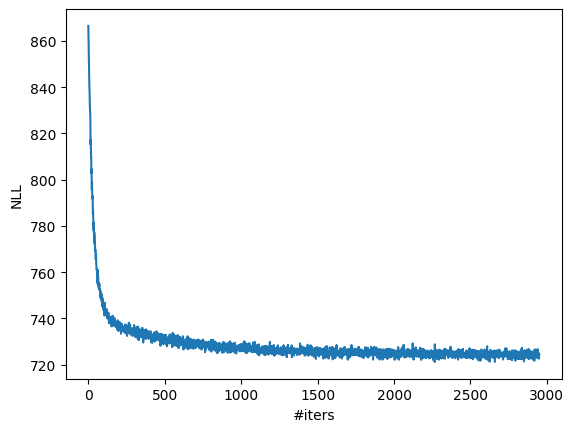

loss: 726.1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:45<00:00, 28.55it/s]


In [305]:
import time

from IPython import display  # type: ignore
from IPython.display import clear_output  # type: ignore

import matplotlib.pyplot as plt
from tqdm import tqdm

pbar = tqdm(range(NUM_ITERS))


for i in pbar:
    
    key = next(chain)
    loss, flow, opt_state = step(key, flow, opt_state)
    # loss, flow, opt_state = step(key, flow, opt_state)  # type: ignore
    agg_loss = agg_loss.update(loss)
    losses.append(loss)
    
    pbar.set_description(f"loss: {loss:.4}")
    if not i % PLOT_INTERVAL:
        
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.ylabel("NLL")
        plt.xlabel("#iters")
    
        plt.show()
        time.sleep(0.001)
        

In [306]:
# from matplotlib.colors import LogNorm
# plt.figure(figsize=(3, 9))
# import itertools as it

# b = data.box[0]
# b = jnp.diag(b) if b.shape != (3,) else b

# oxy = data.positions.reshape(-1, 16, 4, 3)[:, :, 0] % b

# # modes, hist = jax.vmap(jax.vmap(smooth_maximum, in_axes=1, out_axes=0), in_axes=2, out_axes=1)(oxy)
# # oxy = geom.Torus(b).tangent(oxy, modes[None] - oxy)
# # oxy = oxy % b

# k = 5
# for p, (i, j) in enumerate(it.combinations(range(3),2), start=1):
#     print(i,j)
#     plt.subplot(3, 1, p)
#     plt.hist2d(
#         oxy[..., k, i].reshape(-1),
#         oxy[..., k, j].reshape(-1),
#         bins=100,
#         norm=LogNorm(),
#     );
#     # plt.scatter(
#     #     oxy[:, k, i],
#     #     oxy[:, k, j],
#     #     marker="x", c="r"
#     # )
#     plt.scatter(
#         modes[k, i],
#         modes[k, j],
#         marker="o", c="b"
#     )
#     plt.plot(
#         jnp.array([0, b[..., i].max()]),
#         jnp.array([b[..., j].max(), b[..., j].max()]),
#         c="r"
#     )
#     plt.plot(
#         jnp.array([b[..., i].max(), b[..., i].max()]),
#         jnp.array([0, b[..., j].max()]),
#         c="r"
#     )
#     plt.plot(
#         jnp.array([0, b[..., i].max()]),
#         jnp.array([0, 0]),
#         c="r"
#     )
#     plt.plot(
#         jnp.array([0, 0]),
#         jnp.array([0, b[..., j].max()]),
#         c="r"
#     )
#     # plt.xlim(0, b[..., i].max())
#     # plt.ylim(0, b[..., j].max())


In [307]:
# diff = geom.Torus(b).tangent(oxy, modes[None] - oxy)

In [308]:
# oxy_sph = jax.vmap(jax.vmap(to_radial))(diff)
# oxy_ = geom.Torus(b).shift(modes[None], -jax.vmap(jax.vmap(from_radial))(oxy_sph))
# jnp.mean(jnp.abs(oxy - oxy_))

In [309]:
# plt.hist(np.array(oxy_sph.rad[:, :]).reshape(-1), bins=100, log=True);

In [310]:
# k = 0

# # plt.hist(np.array(oxy_sph.rad[:, k]), bins=100);
# plt.figure(figsize=(3, 9))
# for l, (i, j) in enumerate(it.combinations(range(3), 2), start=1):
#     plt.subplot(3, 1, l)
#     plt.hist2d(
#         oxy_sph.rot[:, k, i], oxy_sph.rot[:, k, j],
#         bins=20
#     )

In [311]:
sample_ = jax.jit(jax.vmap(partial(sample_model, flow=flow, prior=pos_prior)))

In [312]:
import numpy as np
chain = key_chain(42)
samples = []

# inv = jax.jit(flow.inverse)



samples = sample_(jax.random.split(next(chain), 10000))
# np.savez("./data/water/samples.npz", positions=np.array(samples))

In [313]:
np.savez("/group/ag_cmb/jonkhler/experiments/rigids/samples.npz", positions=np.array(samples))

0 1
0 2
1 2


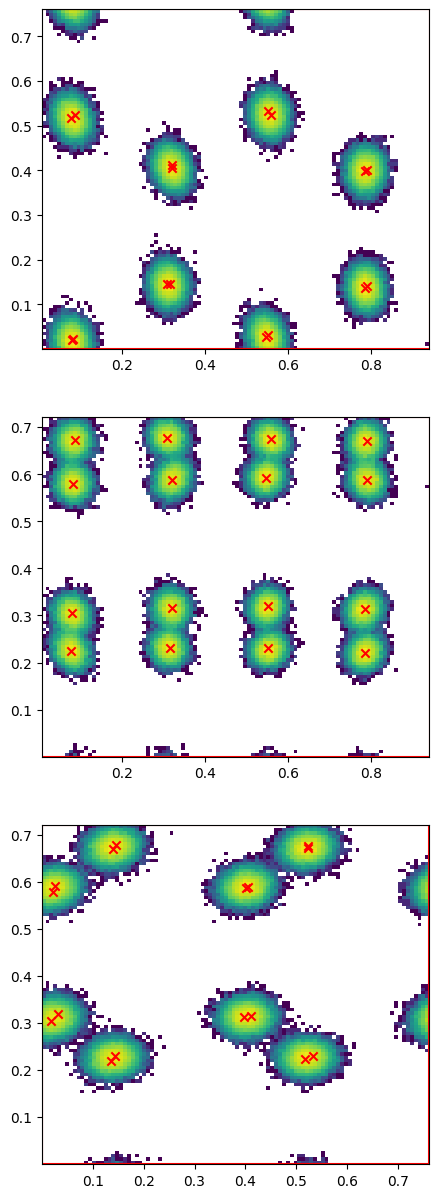

In [314]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(5, 15))
import itertools as it

b = data.box[0]

# samples = jax.vmap(prior.sample)(jax.random.split(next(chain), 10_000))
# oxy_ = samples.reshape(-1, 16, 4, 3)
oxy_ = samples[:, :, 0]
# oxy_ = oxy_ % b

# oxy_ = data.positions.reshape(data.positions.shape[0], -1, 4, 3)[:, :, 0] % BOX.size

# modes = jax.vmap(jax.vmap(smooth_maximum, in_axes=1, out_axes=0), in_axes=2, out_axes=1)(oxy_)



k = 9
for p, (i, j) in enumerate(it.combinations(range(3),2), start=1):
    print(i,j)
    plt.subplot(3, 1, p)
    plt.hist2d(
        oxy_[..., i].reshape(-1),
        oxy_[..., j].reshape(-1),
        bins=100,
        norm=LogNorm(),
    );
    plt.scatter(
        pos_prior.modes[:, i],
        pos_prior.modes[:, j],
        marker="x", c="r"
    )
    plt.plot(
        jnp.array([0, b[i]]),
        jnp.array([b[j], b[j]]),
        c="r"
    )
    plt.plot(
        jnp.array([b[i], b[i]]),
        jnp.array([0, b[j]]),
        c="r"
    )
    plt.plot(
        jnp.array([0, b[i]]),
        jnp.array([0, 0]),
        c="r"
    )
    plt.plot(
        jnp.array([0, 0]),
        jnp.array([0, b[j]]),
        c="r"
    )
